In [1]:
import math
import torch
import numpy as np
import matplotlib.pyplot as plt

import pyro
import pyro.distributions as dist
import pyro.contrib.gp as gp

import torch.optim as optim

import torch.autograd as autograd

# Objective function

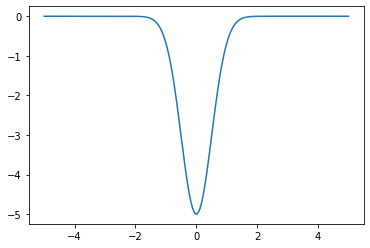

In [2]:
a = -5
b = 0
c = 0.5

def test_function(X):
    return a * torch.exp(-1.0 * torch.pow((X - b), 2) / (2*c*c))

x_ = torch.linspace(-5, 5, 200)

plt.plot(x_, test_function(x_))

# Training data

In [3]:
train_cnt = 3
# X_train = torch.tensor([x for x in np.random.uniform(low=-5, high=5, size=8)])
X_train = torch.tensor([2., 3., -1])
# X_train = torch.tensor([2., 3., -1, -1.5620079040527344])
Y_train = test_function(X_train)

# Model

In [4]:
gpmodel = gp.models.GPRegression(X_train.T, Y_train, 
                                 gp.kernels.Matern52(input_dim=1, lengthscale=torch.ones(1), variance=torch.Tensor([150.0])), 
                                 noise=torch.tensor(0.1), 
                                 jitter=1.0e-4)
gpmodel.kernel.set_prior("lengthscale", dist.LogNormal(0, 1))
gpmodel.kernel.set_prior("variance", dist.LogNormal(0, 1))
gpmodel.set_prior("noise", dist.LogNormal(0, 1))
gpmodel.kernel.autoguide("lengthscale", dist.Normal)
gpmodel.kernel.autoguide("variance", dist.Normal)
gpmodel.autoguide("noise", dist.Normal)

# Optimising GP's parameters

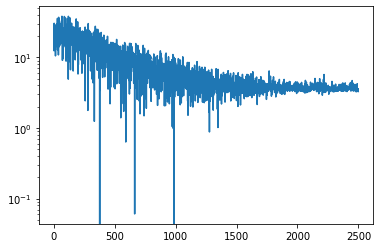

In [5]:
optimizer = torch.optim.Adam(gpmodel.parameters(), lr=0.005)
loss_fn = pyro.infer.Trace_ELBO().differentiable_loss
losses = []
num_steps = 2500
for i in range(num_steps):
    optimizer.zero_grad()
    loss = loss_fn(gpmodel.model, gpmodel.guide)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
plt.semilogy(losses)

# Expected improvement

In [6]:
normal_phi = lambda x: torch.exp(-x.pow(2)/2)/np.sqrt(2*np.pi)
normal_Phi = lambda x: (1 + torch.erf(x / np.sqrt(2))) / 2
  
def expected_improvement(x):
    y_min = gpmodel.y.min()
    mu, variance = gpmodel(x, full_cov=False, noiseless=False)
    sigma = variance.sqrt()
    delta = y_min - mu
    EI = delta.clamp_min(0.0) + sigma*normal_phi(delta/sigma) - delta.abs()*normal_Phi(delta/sigma)
    return -EI


# Lower confidence bound

In [7]:
def lower_confidence_bound(x, kappa=2):
    
    mu, variance = gpmodel(x, full_cov=False, noiseless=False)
    sigma = variance.sqrt()
    
    return mu - kappa * sigma

## Look at model

In [8]:
list(gpmodel.named_buffers())

[('noise', tensor(0.2977, grad_fn=<ExpandBackward>)),
 ('noise_scale', tensor(0.9005, grad_fn=<AddBackward0>)),
 ('kernel.variance', tensor([0.6792], grad_fn=<ExpandBackward>)),
 ('kernel.lengthscale', tensor([6.1347], grad_fn=<ExpandBackward>)),
 ('kernel.lengthscale_scale', tensor([0.9772], grad_fn=<AddBackward0>)),
 ('kernel.variance_scale', tensor([0.9762], grad_fn=<AddBackward0>))]

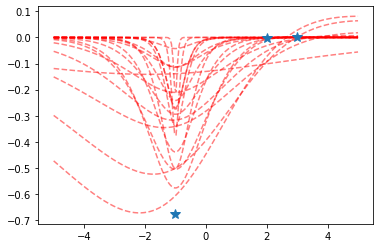

In [9]:

def plot_mu(x, kappa=2):
    
    mu, variance = gpmodel(x, full_cov=False, noiseless=False)
    plt.plot(x, mu, 'r--', alpha=0.5)
    
with torch.no_grad():
    for i in range(20):
        plot_mu(x_)
plt.plot(X_train, Y_train, "*", markersize=10);

# Plotting

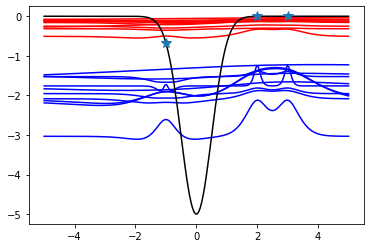

In [10]:
for i in range(10):
    plt.plot(x_, expected_improvement(x_).detach().numpy(), color="red")
    plt.plot(x_, lower_confidence_bound(x_).detach().numpy(), color="blue")
plt.plot(x_, test_function(x_), color="black")
plt.plot(X_train, Y_train, "*", markersize=10);

## Compare expected expected improvement to samples of expected improvement

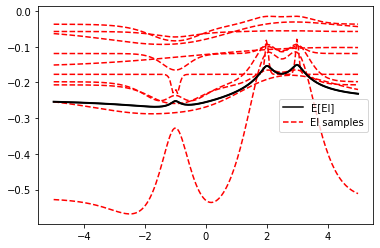

In [11]:
acq = np.mean([expected_improvement(x_).detach().numpy() for _ in range(1000)], 0)

plt.plot(x_, acq, 'k');

for _ in range(10):
    plt.plot(x_, expected_improvement(x_).detach().numpy(), 'r--');
    
plt.plot(x_, acq, 'k', linewidth=2);
plt.legend(['E[EI]', 'EI samples']);

In [12]:
x_[acq.argmin()]

tensor(-1.6834)

# Minimising acquisition function

In [13]:
def optimise(acquisition_func, x_st):
    
    # unconstrained minimiser
    # minimizer = optim.LBFGS([x_st], max_iter=100) #, line_search_fn='strong_wolfe')
    minimizer = optim.Adam([x_st], lr=0.01)
    
    def closure():
        # clear gradients
        minimizer.zero_grad()

        y = acquisition_func(x_st)

        autograd.backward(x_st, autograd.grad(y, x_st))

#         print("x_st", x_st)

        return x_st, y

    hist = []
    hist_y = []
    for _ in range(1000):
        x_st, y = minimizer.step(closure)
        hist.append(x_st.item())
        hist_y.append(y.item())
        
    print(x_st.item());
    return hist, hist_y

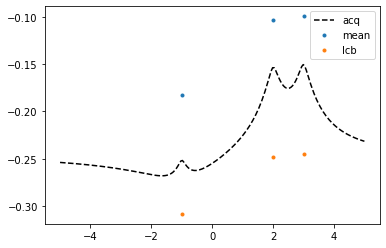

In [14]:
train_samples = torch.stack([expected_improvement(X_train) for _ in range(10)])


# init = X_train[best_ix.item()]
# init

with torch.no_grad():
    plt.plot(x_, acq, 'k--');
    plt.plot(X_train, train_samples.mean(0), '.')
    plt.plot(X_train, train_samples.mean(0) - 2*train_samples.std(0),'.')
    
plt.legend(['acq', 'mean', 'lcb']);

-1.7286139726638794


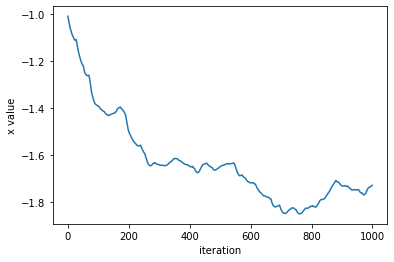

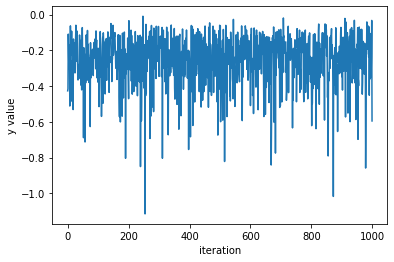

In [15]:
LCB = train_samples.mean(0) - 2*train_samples.std(0)
init = X_train[LCB.argmin().item()].item()

x_st = torch.Tensor([init]).detach().requires_grad_(True)
hist, hist_y = optimise(expected_improvement, x_st)
plt.plot(hist);
plt.ylabel("x value")
plt.xlabel("iteration")
plt.figure()
plt.plot(hist_y);
plt.ylabel("y value")
plt.xlabel("iteration");
# iterates = np.arange(1,(len(hist)+1))
# w = 0.99**(iterates[::-1])
# plt.plot(np.cumsum(hist)/np.arange(1,len(hist)+1));

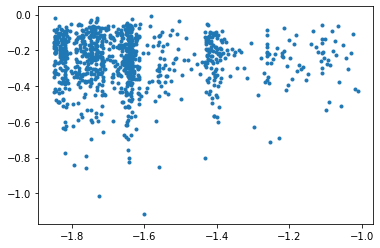

In [16]:
plt.plot(hist, hist_y, '.');

## Select next point (by taking last point of gradient descent run…?)

In [17]:
found = hist[-1]
print("suggested point:", found)

suggested point: -1.7286139726638794


### Plot distribution of expected improvement at different points…?

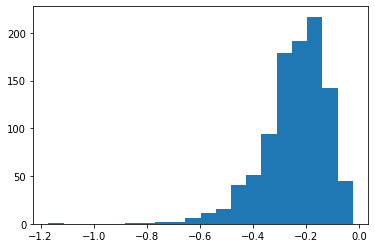

In [18]:
with torch.no_grad():
    at_init = torch.cat([expected_improvement(torch.tensor([init])) for _ in range(1000)])
    plt.hist(at_init, bins=20);

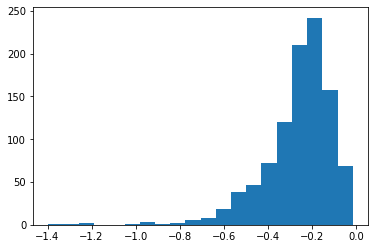

In [19]:
with torch.no_grad():
    at_best = torch.cat([expected_improvement(torch.tensor([x_[acq.argmin()].item()])) for _ in range(1000)])
    plt.hist(at_best, bins=20);

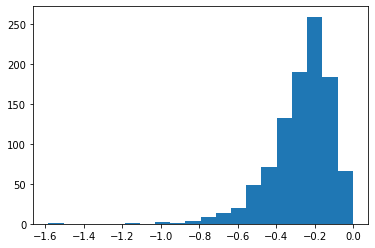

In [20]:
with torch.no_grad():
    at_found = torch.cat([expected_improvement(torch.tensor([found])) for _ in range(1000)])
    plt.hist(at_found, bins=20);

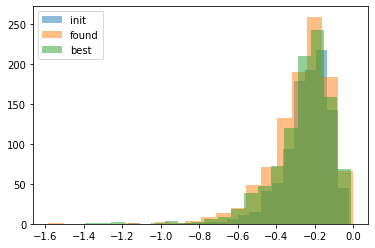

In [21]:
plt.hist(at_init, bins=20, alpha=0.5);
plt.hist(at_found, bins=20, alpha=0.5);
plt.hist(at_best, bins=20, alpha=0.5);

plt.legend(['init', 'found', 'best']);

In [22]:
# x_st = torch.Tensor([-1.0]).detach().requires_grad_(True)
# optimise(lower_confidence_bound, x_st)